# Study of COVID data in the US (based on NYT data)

In [209]:
import pandas as pd
import numpy as np
import matplotlib
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import seaborn as sns
sns.set()

In [210]:
# matplotlib.style.use('seaborn-whitegrid')

## Get NYT data and prepare it

In [211]:
# Read from NYT data CSV
df_ = pd.read_csv('us-states.csv')

In [212]:
# Make date string a proper datetime data type
df_['date']=df_['date'].apply(lambda x:pd.Timestamp(x))
# Maje it a time series
# df_.set_index('date',inplace=True)
df_.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [213]:
# Add states abbreviations
df_abb = pd.read_csv('other_input/us-states-abbreviations.csv')
df = pd.merge(left=df_, right=df_abb, on='state', how='outer')
df.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
0,2020-01-21,Washington,53,1,0,Wash.,WA
1,2020-01-22,Washington,53,1,0,Wash.,WA
2,2020-01-23,Washington,53,1,0,Wash.,WA
3,2020-01-24,Washington,53,1,0,Wash.,WA
4,2020-01-25,Washington,53,1,0,Wash.,WA


In [214]:
last_date = df.date.max()
last_date

Timestamp('2020-07-28 00:00:00')

## States ranked by number of cases

In [215]:
# States with most cases (on last available date)
df_ti = df[df['date'] == last_date].sort_values(by='cases', ascending=False)
# df_ti.set_index('date', inplace=True, drop=False)
df_ti.head()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
562,2020-07-28,California,6,474951,8716,Calif.,CA
1889,2020-07-28,Florida,12,441969,6116,Fla.,FL
2039,2020-07-28,New York,36,417591,32333,N.Y.,NY
1269,2020-07-28,Texas,48,412744,6515,Tex.,TX
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


Text(0.5, 1.0, 'Total number of cases per State (on July 28, 2020)')

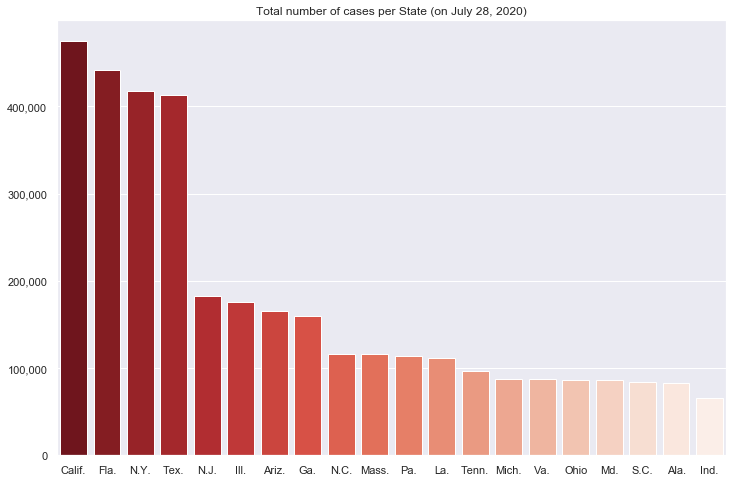

In [216]:
# Plot the States ranked by number of cases
fig, ax = plt.subplots(figsize=(12, 8))
number_of_states_to_visualize = 20
df_ti_p = df_ti.head(number_of_states_to_visualize).copy()
x = df_ti_p['Abbreviation']
y = df_ti_p['cases']
# bar_container = ax.bar(x=x, height=y)
sns.barplot(x=x, y=y, palette='Reds_r', ax=ax)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x,p: format(int(x),',')))
ax.get_xaxis().label.set_visible(False)
ax.get_yaxis().label.set_visible(False)
ax.set_title(f'Total number of cases per State (on {last_date.strftime("%B %d, %Y")})')

In [217]:
# fig.savefig(f'output_visuals/Total_number_of_Cases_{last_date.strftime("%B_%d_%Y")}.png')

## Evolution of number of cases per state

In [265]:
# Number of states considered (among top impacted)
nb_states_time_plot = 10
df_states_considered = df_ti['state'].head(nb_states_time_plot)
# index on the most impacted states only
boolean_index = df['state'].isin(df_states_considered)
# df time plot
df_tp = df[boolean_index]
df_tp.tail()

,date,state,fips,cases,deaths,Abbreviation,Postal Code
2778,2020-07-24,New Jersey,34,180265,15765,N.J.,NJ
2779,2020-07-25,New Jersey,34,180778,15776,N.J.,NJ
2780,2020-07-26,New Jersey,34,181283,15787,N.J.,NJ
2781,2020-07-27,New Jersey,34,181732,15804,N.J.,NJ
2782,2020-07-28,New Jersey,34,182215,15825,N.J.,NJ


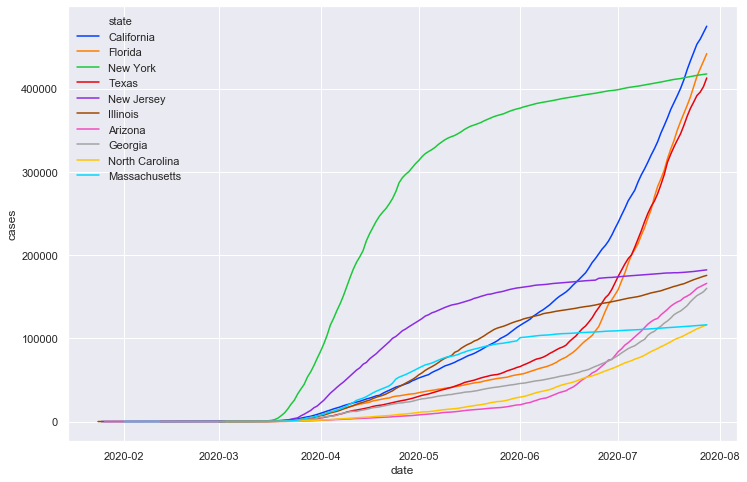

In [266]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='date', y='cases', hue='state', palette='bright', hue_order=df_states_considered,
             ax=ax, data=df_tp)

In [262]:
fig.savefig(f'output_visuals/Evolution_total_number_of_cases_through_time_' \
            f'{last_date.strftime("%B_%d_%Y")}.png')

## Sates ranked per number of cases

In [220]:
last_timestamp = df.index.sort_values()[-1]

In [221]:

df[last_timestamp:].sort_values(by='cases',ascending=False).head(10)

,date,state,fips,cases,deaths,Abbreviation,Postal Code
8153,2020-07-28,Northern Mariana Islands,69,40,2,NaN,NaN


In [222]:
df_summary = df.loc[last_timestamp:, ['cases', 'deaths']].sum().copy()
df_summary.index.values

array(['cases', 'deaths'], dtype=object)

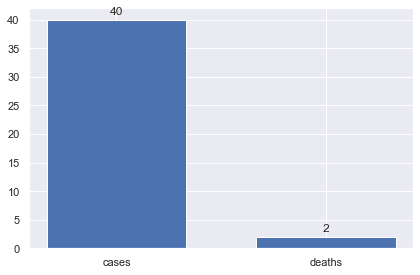

In [223]:
fig, ax = plt.subplots()
rects = ax.bar(x=[0, 0.3], height=df_summary.values, width=0.2, tick_label=df_summary.index.values)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)

fig.tight_layout()


### Mortality rate

In [224]:
df_summary['deaths'] / df_summary['cases']

0.05

## Number of New Cases per day (for a list of states)

In [225]:
states_list = ["New York","New Jersey","California","Michigan","Massachusetts","Florida","Washington","Illinois","Pennsylvania","Louisiana", "Texas"]

In [226]:
df_states_list = []

In [227]:
# Iterate over all states, create the df and append to the list
for i,state in enumerate(states_list):
    # create a local copy of the df
    df_state = df[df.state == state].copy()
    # calculate the number of new cases per day
    df_state['new cases'] = df_state['cases'] - df_state['cases'].shift(1)
    df_state.fillna(0,inplace=True)
    # calculate SMA
    df_state['SMA'] = ( df_state['new cases'] + df_state['new cases'].shift(1) + df_state['new cases'].shift(2) )*1/3
    # append the df of that state to the list
    df_states_list.append(df_state)

In [228]:
# df_states_list[0].tail()

### PLOT OF NEW CASES (for the 4 most impacted states)

In [229]:
def my_new_cases_plotter(df_list,states_list):

    nb_columns_fig = 2
    nb_rows_fig = 6
#     If more than 4 grapghs, extend the rows
#     if len(df_list) > 4:
#         nb_rows_fig = int((np.ceil(len(df_list) / nb_columns_fig)))
    
    fig, ax_arr = plt.subplots(nb_rows_fig, nb_columns_fig)  # create a figure with a 'rows x columns' grid of axes
    fig.set_size_inches(16,24)
    fig.suptitle("New cases registered per day")
    
    for df_index in range(len(df_list)):  # iterate over all the data frames to plot
    
        i_fig = int((np.floor(df_index / nb_columns_fig)))  # row position of the axes on that given figure
        j_fig = int((df_index % nb_columns_fig))  # column position of the axes on that given figure

        df = df_list[df_index].loc['20200301':]  # df to plot at that position

        ax_arr[i_fig,j_fig].bar(x=df['new cases'].index,height=df['new cases'],color="#900C3F")
        ax_arr[i_fig,j_fig].plot(df['new cases'].index,df['SMA'],color="#FFC300")

        ax_arr[i_fig,j_fig].xaxis.set_major_locator(WeekdayLocator(MONDAY))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_locator(DayLocator())
        ax_arr[i_fig,j_fig].xaxis.set_major_formatter(DateFormatter('%d'))
#         ax_arr[i_fig,j_fig].xaxis.set_minor_formatter(DateFormatter('%d'))
        ax_arr[i_fig,j_fig].set_title(states_list[df_index])
    return fig
        

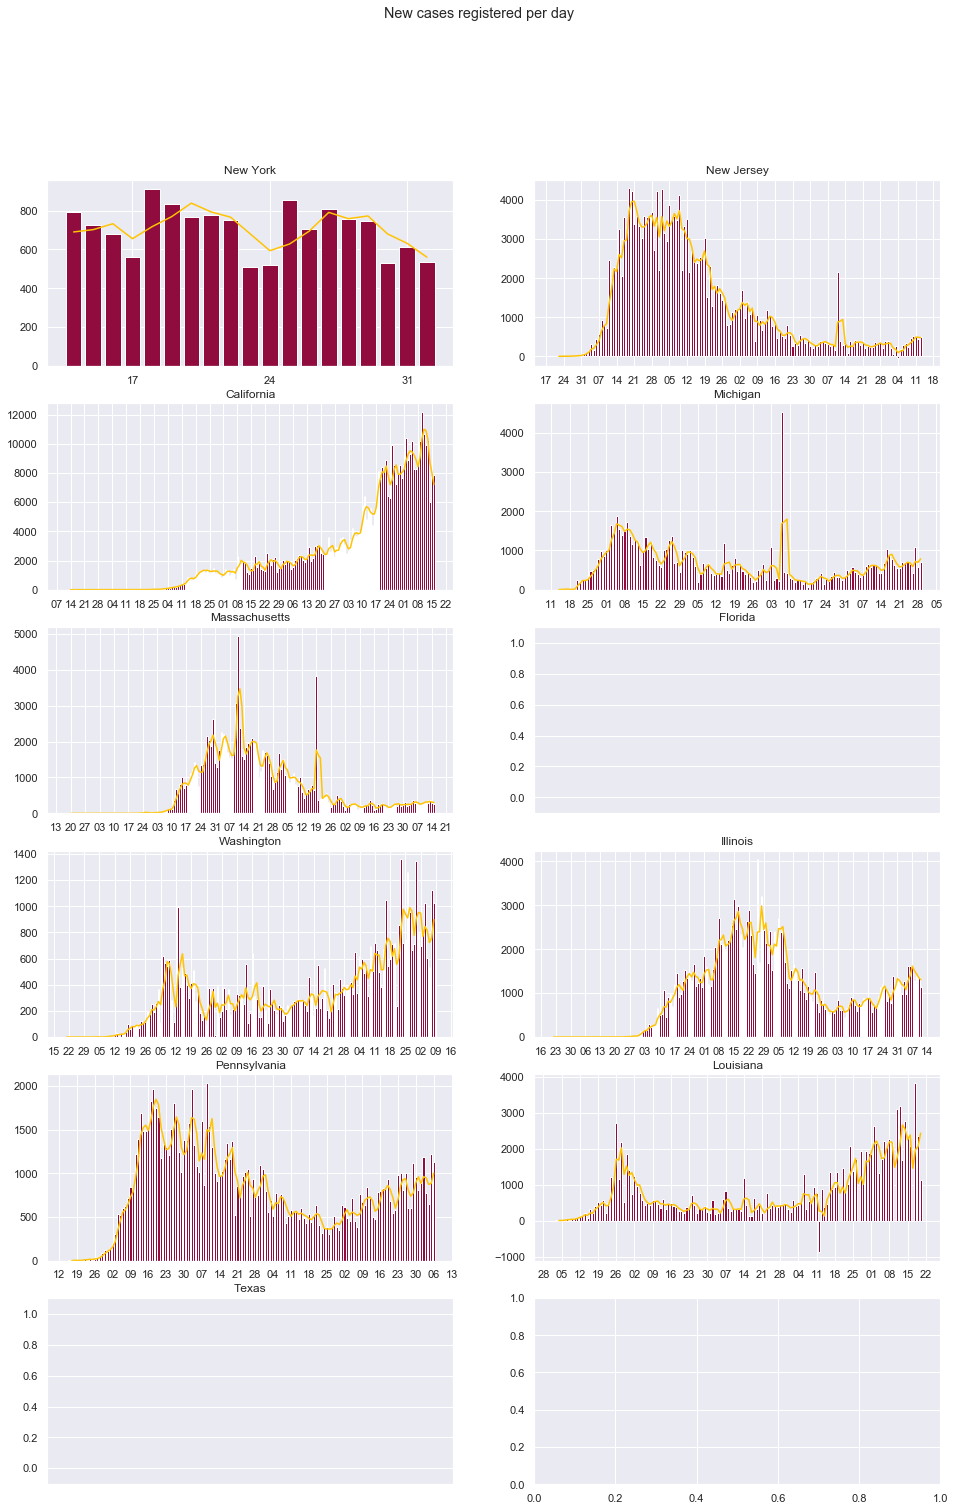

In [230]:
fig = my_new_cases_plotter(df_states_list,states_list)

In [231]:
# fig.savefig('covid_per_US_state.png')